In [2]:
%load_ext autoreload
%autoreload 2

# Examining ChiX

## Imports

In [3]:
import os
from subprocess import Popen, PIPE

import ViennaRNA
from varnaapi import Structure
from synbio_morpher.utils.data.data_format_tools.manipulate_fasta import load_seq_from_FASTA
from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.srv.parameter_prediction.simulator import process_raw_stdout
from synbio_morpher.utils.common.setup import prepare_config, expand_config
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict

import numpy as np
import pandas as pd

In [4]:
fn = os.path.join('..', 'data', 'sRNA', 'merged_inter.csv')
fn_merged = os.path.join('..', 'data', 'sRNA', 'merged_EcoCyc_RNAInter_sRNATarBase.csv')
data = pd.read_csv(fn)
data_merged = pd.read_csv(fn_merged)

try:
    data = data.drop(columns='Unnamed: 0')
    data_merged = data_merged.drop(columns='Unnamed: 0')
except:
    pass

In [5]:
def show_rna_structure(rna_structure, seq, resolution = 3, algorithm = 'radiate', annotate: bool = False):
    try:
        v = Structure(structure=rna_structure, sequence=seq)
        v._params['resolution'] = resolution
        v._params['algorithm'] = algorithm
        if annotate:
            v._params['autoHelices'] = True
            v._params['autoInteriorLoops'] = True
            v._params['autoTerminalLoops'] = True
        v.show()
        # v.savefig("example.png", show=True)
    except FileNotFoundError:
        print('No Java found, could not visualise')
        pass

    

In [6]:
chix = data[(data['Interactor 1'] == 'chiX') | (data['Interactor 2'] == 'chiX')]

['java', '-cp', './VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', 'ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCCTCTTTGACGGGCCAATAGCGATATTGGCCATTTTTTT', '-structureDBN', '...((((((((...)))))))).........(((((((((.....((........))(((((((....))))))))))))))))', '-o', '/tmp/tmpsqhf5t2z.png', '-resolution', '3']


Output file: /tmp/tmpsqhf5t2z.png



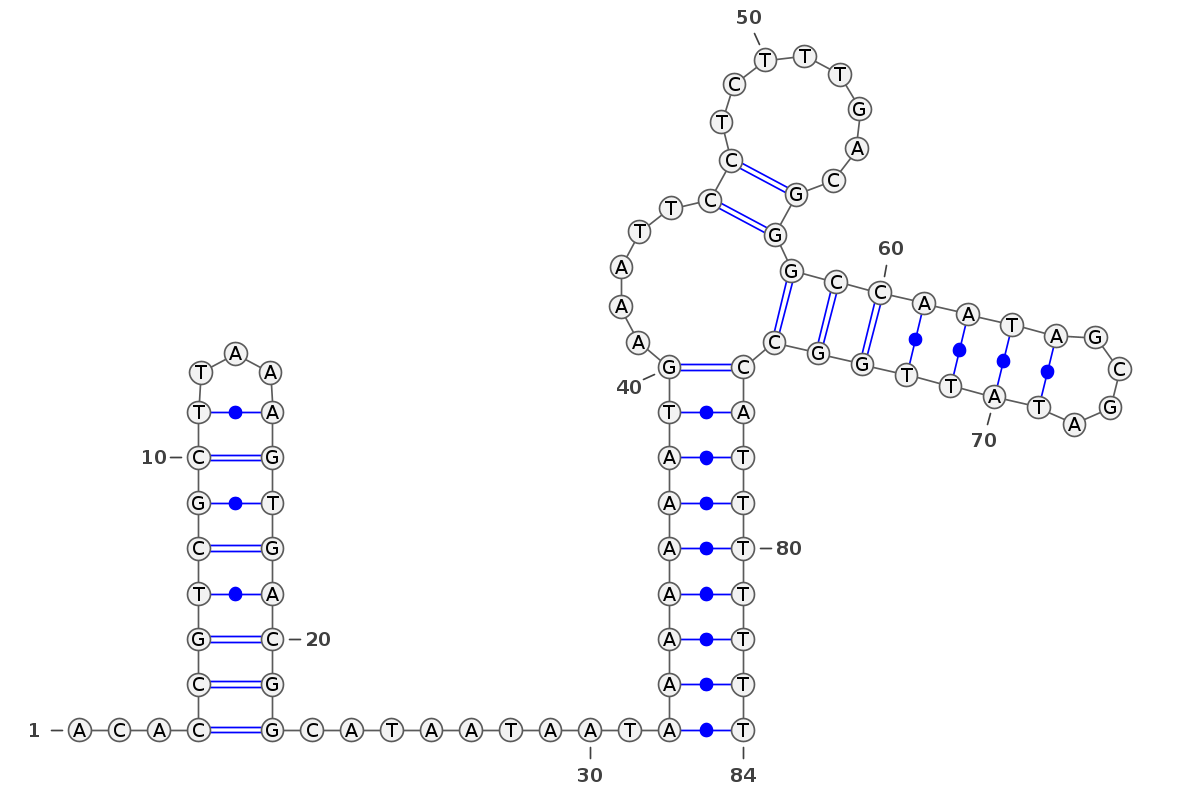

In [7]:
s = ''
# ChiX
seq = chix['Sequence 1'].iloc[0] if chix['Interactor 1'].iloc[0] == 'chiX' else chix['Sequence 2'].iloc[0]
folded = ViennaRNA.fold(seq, s)
folded

show_rna_structure(folded[0], seq)

# Scott's mutations

In [8]:
fn_mutations = os.path.join('data', 'scott_mutations.fasta')

muts = load_seq_from_FASTA(fn_mutations, as_type='dict')


In [9]:
print('Synthetic sequence \t', muts['Syn_ChiX_20-D'])
print('Normal sequence \t', chix['Sequence 1'].iloc[0] if chix['Interactor 1'].iloc[0] == 'chiX' else chix['Sequence 2'].iloc[0])

Synthetic sequence 	 ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCTTCTCCTTTACGCATATGGCCAATAGCGATATTGGCCATTTTTTT
Normal sequence 	 ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCCTCTTTGACGGGCCAATAGCGATATTGGCCATTTTTTT


['java', '-cp', './VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', 'ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCTTCTCCTTTACGCATATGGCCAATAGCGATATTGGCCATTTTTTT', '-structureDBN', '...((((((((...)))))))).......................................((((((((((....))))))))))......', '-o', '/tmp/tmpu5j62_xc.png', '-resolution', '3']


Output file: /tmp/tmpu5j62_xc.png



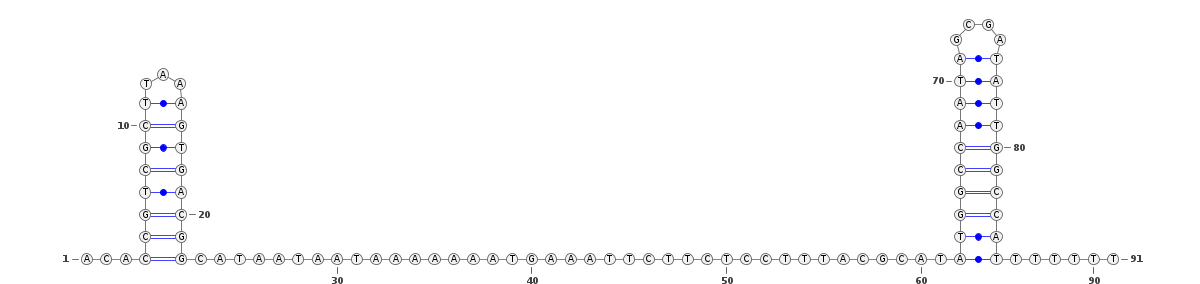

In [10]:
s = ''
# Synthetic ChiX
seq = muts['Syn_ChiX_20-D']
folded = ViennaRNA.fold(seq, s)
folded

show_rna_structure(folded[0], seq)

# v.savefig("example.png", show=True)

In [11]:
chix

,Interactor 1,Interactor 2,ID 1,ID 2,Category 1,Category 2,Regulation,Binding position 1,Binding position 2,Sequence 1,Sequence 2,Source DB
279,chiX,rpoS,"chromosome:NC_000913.3, Gene ID:5061500","chromosome:NC_000913.3, Gene ID:947210",NaN,mRNA,No Interaction,['NA'],['NA'],ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTC...,ATGAGTCAGAATACGCTGAAAGTTCATGATTTAAATGAAGATGCGG...,sRNATarBase
353,chiX,citA,"chromosome:NC_000913.3, Gene ID:5061500","chromosome:NC_000913.3, Gene ID:945233",trans-encoded antisense RNA,mRNA,Repression,['46..57'],['-37..-26'],ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTC...,ATGTTGCAGCTTAACGAGAATAAACAGTTTGCATTTTTCCAAAGAC...,sRNATarBase
374,chiX,chiP,"chromosome:NC_000913.3, Gene ID:5061500","chromosome:NC_000913.3, Gene ID:945296",trans-encoded antisense RNA,mRNA,Repression,['81..92'],['45..56'],ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTC...,ATGCGTACGTTTAGTGGCAAACGTAGTACGCTGGCGCTGGCTATCG...,sRNATarBase
408,chiX,chbC,"chromosome:NC_000913.3, Gene ID:5061500","chromosome:NC_000913.3, Gene ID:945982",trans-encoded antisense RNA,mRNA,Repression,['NA'],['NA'],ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTC...,ATGAGTAATGTTATTGCATCGCTTGAAAAGGTACTCCTCCCTTTTG...,sRNATarBase


## Add EGFP and cyRFP1 to targets

The sequence for EGFP can be found via the [Fluorescent Protein Database](https://www.fpbase.org/protein/egfp/) and is the following:

MVSKGEELFT GVVPILVELD GDVNGHKFSV SGEGEGDATY GKLTLKFICT TGKLPVPWPT LVTTLTYGVQ CFSRYPDHMK QHDFFKSAMP EGYVQERTIF FKDDGNYKTR AEVKFEGDTL VNRIELKGID FKEDGNILGH KLEYNYNSHN VYIMADKQKN GIKVNFKIRH NIEDGSVQLA DHYQQNTPIG DGPVLLPDNH YLSTQSALSK DPNEKRDHMV LLEFVTAAGI TLGMDELYK

The source DNA for EGFP can be found on [Addgene](https://www.addgene.org/54762/):

ATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGC
AAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCCTGACCTACGGCGTGCAGTGCTTCAGCCGCTACCCCGACCACATGAAGCAGCAC
GACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGC
ATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAGGTG
AACTTCAAGATCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAG
TCCGCCCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGTAA


The source for cyRFP1 can also be found on [Addgene](https://www.addgene.org/84356/):

ATGGTGAGCAAGGGCGAGGAGCTGATCAAGGAGAACATGAGAAGCAAGCTGTACCTGGAAGGCAGCGTGAACGGCCACCAGTTCAAGTGCACCCACGAAGGGGAGGGCAAGCCCTACGAGGGC
AAGCAGACCAACAGGATCAAGGTGGTGGAGGGAGGCCCCCTGCCGTTCGCATTCGACATCCTGGCCACCATGTTTATGTACGGGAGCAAGGTGTTCATCAAGTACCCCGCCGACCTCCCCGAT
TATTTTAAGCAGTCCTTCCCTGAGGGCTTCACATGGGAGAGAGTCATGGTGTTCGAAGACGGGGGCGTGCTGACCGCCACCCAGGACACCAGCCTCCAGGACGGCGAGCTCATCTACAACGTC
AAGCTCAGAGGGGTGAACTTCCCAGCCAACGGCCCCGTGATGCAGAAGAAAACACTGGGCTGGGAGCCCAGCACCGAGACCATGTACCCCGCTGACGGCGGCCTGGAAGGCAGATGCGACAAG
GCCCTGAAGCTCGTGGGCGGGGGCCACCTGCACGTCAACTTCAAGACCACATACAAGTCCAAGAAACCCGTGAAGATGCCCGGCGTCCACTACGTGGACCGCAGACTGGAAAGAATCAAGGAG
GCCGACAACGAGACCTACGTCGAGCAGTACGAGCACGCTGTGGCCAGATACTCCAACCTGGGCGGAGGCATGGACGAGCTGTACAA

In [12]:
egfp_seq = 'ATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCCTGACCTACGGCGTGCAGTGCTTCAGCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGATCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCGCCCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGTAA'
cyrfp1_seq = 'ATGGTGAGCAAGGGCGAGGAGCTGATCAAGGAGAACATGAGAAGCAAGCTGTACCTGGAAGGCAGCGTGAACGGCCACCAGTTCAAGTGCACCCACGAAGGGGAGGGCAAGCCCTACGAGGGCAAGCAGACCAACAGGATCAAGGTGGTGGAGGGAGGCCCCCTGCCGTTCGCATTCGACATCCTGGCCACCATGTTTATGTACGGGAGCAAGGTGTTCATCAAGTACCCCGCCGACCTCCCCGATTATTTTAAGCAGTCCTTCCCTGAGGGCTTCACATGGGAGAGAGTCATGGTGTTCGAAGACGGGGGCGTGCTGACCGCCACCCAGGACACCAGCCTCCAGGACGGCGAGCTCATCTACAACGTCAAGCTCAGAGGGGTGAACTTCCCAGCCAACGGCCCCGTGATGCAGAAGAAAACACTGGGCTGGGAGCCCAGCACCGAGACCATGTACCCCGCTGACGGCGGCCTGGAAGGCAGATGCGACAAGGCCCTGAAGCTCGTGGGCGGGGGCCACCTGCACGTCAACTTCAAGACCACATACAAGTCCAAGAAACCCGTGAAGATGCCCGGCGTCCACTACGTGGACCGCAGACTGGAAAGAATCAAGGAGGCCGACAACGAGACCTACGTCGAGCAGTACGAGCACGCTGTGGCCAGATACTCCAACCTGGGCGGAGGCATGGACGAGCTGTACAA'

egfp = chix.iloc[-1][['Interactor 1', 'ID 1', 'Category 1', 'Binding position 1', 'Sequence 1']].to_dict()
for k, v in zip(['Interactor 2', 'ID 2', 'Category 2', 'Regulation', 'Binding position 2', 'Sequence 2', 'Source DB'], ['EGFP', 'https://www.addgene.org/54762/', 'mRNA', 'Repression', "['NA']", egfp_seq, 'Addgene']):
    egfp[k] = [v]
cyrfp1 = chix.iloc[-1][['Interactor 1', 'ID 1', 'Category 1', 'Binding position 1', 'Sequence 1']].to_dict()
for k, v in zip(['Interactor 2', 'ID 2', 'Category 2', 'Regulation', 'Binding position 2', 'Sequence 2', 'Source DB'], ['cyRFP1', 'https://www.addgene.org/84356/', 'mRNA', 'Activator', "['NA']", cyrfp1_seq, 'Addgene']):
    cyrfp1[k] = [v]
    
chix = pd.concat([chix, pd.DataFrame.from_dict(egfp)])
chix = pd.concat([chix, pd.DataFrame.from_dict(cyrfp1)])
chix

,Interactor 1,Interactor 2,ID 1,ID 2,Category 1,Category 2,Regulation,Binding position 1,Binding position 2,Sequence 1,Sequence 2,Source DB
279,chiX,rpoS,"chromosome:NC_000913.3, Gene ID:5061500","chromosome:NC_000913.3, Gene ID:947210",NaN,mRNA,No Interaction,['NA'],['NA'],ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTC...,ATGAGTCAGAATACGCTGAAAGTTCATGATTTAAATGAAGATGCGG...,sRNATarBase
353,chiX,citA,"chromosome:NC_000913.3, Gene ID:5061500","chromosome:NC_000913.3, Gene ID:945233",trans-encoded antisense RNA,mRNA,Repression,['46..57'],['-37..-26'],ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTC...,ATGTTGCAGCTTAACGAGAATAAACAGTTTGCATTTTTCCAAAGAC...,sRNATarBase
374,chiX,chiP,"chromosome:NC_000913.3, Gene ID:5061500","chromosome:NC_000913.3, Gene ID:945296",trans-encoded antisense RNA,mRNA,Repression,['81..92'],['45..56'],ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTC...,ATGCGTACGTTTAGTGGCAAACGTAGTACGCTGGCGCTGGCTATCG...,sRNATarBase
408,chiX,chbC,"chromosome:NC_000913.3, Gene ID:5061500","chromosome:NC_000913.3, Gene ID:945982",trans-encoded antisense RNA,mRNA,Repression,['NA'],['NA'],ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTC...,ATGAGTAATGTTATTGCATCGCTTGAAAAGGTACTCCTCCCTTTTG...,sRNATarBase
0,chiX,EGFP,"chromosome:NC_000913.3, Gene ID:5061500",https://www.addgene.org/54762/,trans-encoded antisense RNA,mRNA,,['NA'],['NA'],ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTC...,ATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCC...,Addgene
0,chiX,cyRFP1,"chromosome:NC_000913.3, Gene ID:5061500",https://www.addgene.org/84356/,trans-encoded antisense RNA,mRNA,,['NA'],['NA'],ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTC...,ATGGTGAGCAAGGGCGAGGAGCTGATCAAGGAGAACATGAGAAGCA...,Addgene


# Analyse synthetic chiX binding to all targets

In [13]:

s = 'syn_chiX'
mrnas = {m['Interactor 2']: m['Sequence 2']
         for i, m in chix[['Interactor 2', 'Sequence 2']].iterrows()}

### Run IntaRNA

In [13]:
config = {
    "experiment": {
        "purpose": "tests",
    },
    "data": {},
    "system_type": "RNA",
    "interaction_simulator": {
        "name": "IntaRNA",
        "postprocess": True,
        "simulator_kwargs": {
            "outcsvcols": "id1, id2, E, E_norm, bpList, hybridDPfull, seedPu1, seedPu2, seedStart1, seedStart2, seedEnd1, seedEnd2",
            "threads": 12,
            "n": 1,
            "raw_stdout": True
        }
    },
    "molecular_params": {
        "avg_mRNA_per_cell": 100,
        "cell_doubling_time": 1200,
        "creation_rate": 2.35,
        "starting_copynumbers": 200,
        "degradation_rate": 0.01175,
        "association_binding_rate": 1000000
    }
}

data_writer = None
config, data_writer = script_preamble(config, data_writer)
config_file = prepare_config(expand_config(config=config))

In [36]:
config['interaction_simulator']['simulator_kwargs']['outcsvcols'] = "id1, id2, E, E_norm, bpList, hybridDPfull, seedPu1, seedPu2, seedStart1, seedStart2, seedEnd1, seedEnd2"

In [37]:
def simulate_IntaRNA_local(query: dict,
                           targets: dict,
                           sim_kwargs={}):
    fn1 = data_writer.output(data=query, out_type='fasta',
                             out_name='query', byseq=True, return_path=True)
    fn2 = data_writer.output(data=targets, out_type='fasta',
                             out_name='targets', byseq=True, return_path=True)
    sim_kwargs['query'] = fn1
    sim_kwargs['target'] = fn2

    def run(query: str, target: str, qidxpos0: int, tidxpos0: int, outcsvcols: str, threads: int, n: int = 1,
            param_file: str = '', extra_params: list = [], raw_stdout: bool = False):
        p = Popen(['IntaRNA', '-q', query, '-t', target,
                   '--outMode=C', f'--outcsvcols={outcsvcols}',
                   f'--qIdxPos0={qidxpos0}',
                   f'--tIdxPos0={tidxpos0}',
                   f'--outNumber={n}',
                   f'--threads={threads}', param_file]
                  + extra_params, stdout=PIPE, stderr=PIPE, universal_newlines=True)
        stdout, stderr = p.communicate()
        return process_raw_stdout(stdout)

    return run(**sim_kwargs)


def write_dbn(outname, outdir, id_name, seq, db):
    fn = os.path.join(outdir, outname + '.dbn')
    with open(fn, 'w') as f:
        f.writelines('>' + id_name + '\n' +
                     seq + '\n' +
                     db + '\n')
    return fn


# bpRNA

# def execute_perl_script(*args):
#     """ Bard """
#     script_path = './bpRNA.pl'
#     try:
#         subprocess.run(["perl", script_path, *args])
#     except Exception as e:
#         print(f"Error executing Perl script: {e}")


# for k1 in sim_data_l:
#     data_writer.subdivide_writing('st')
#     data_writer.subdivide_writing(k1, safe_dir_change=False)
#     data_writer.unsubdivide()
#     data_writer.subdivide_writing('dbn')
#     data_writer.subdivide_writing(k1, safe_dir_change=False)

#     for k2 in sim_data_l[k1]:
#         bplist = sim_data_l[k1][k2]['bpList']
#         # make_db(bplist, seq_len=len(db))
#         db = sim_data_l[k1][k2]['hybridDPfull'].replace('&', '')
#         seq = merged[merged['Symbol'] == k1]['Sequence'].iloc[0] + \
#             merged[merged['Symbol'] == k2]['Sequence'].iloc[0]
#         fn = write_dbn(k1 + '_' + k2, data_writer.write_dir, id_name='arcZ', seq=seq, db=db)
#         try:
#             execute_perl_script(fn, fn.replace('.dbn', '').replace('dbn', 'st'))
#         except:
#             print(k1, k2)

sim_data = {}
sim_data[s] = {}
sim_data[s] = simulate_IntaRNA_local(query={s: muts['Syn_ChiX_20-D']},
                                     targets=mrnas,
                                     sim_kwargs=config_file['interaction_simulator']['simulator_kwargs'])

data_writer.output(data=sim_data, out_type='json',
                   out_name='inter_data_raw', overwrite=True)

### Load back in

In [39]:
fn = './data/tests/2023_11_28_205928/inter_data_raw.json'
sim_data_l = load_json_as_dict(fn)

sim_data_l

{'syn_chiX': {'EGFP': {'id1': 'EGFP',
   'id2': 'syn_chiX',
   'E': '-7.07',
   'E_norm': '-0.637505',
   'bpList': '(469,54):(470,53):(471,52):(473,50):(474,49):(475,48):(476,47):(477,46):(478,45):(479,44)',
   'hybridDPfull': '....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................(((.(((((((.................................................................................................................................................................................................................................................&...........................................)))))))

In [31]:
sim_data_l.keys()

dict_keys(['syn_chiX', 'EGFP', 'cyRFP1'])

In [20]:
k = list(sim_data_l['syn_chiX'].keys())[0]
print(sim_data_l['syn_chiX'][k]['hybridDPfull'].replace('&', '\n'))

....................................................................................................................................................................................................................................................................................................................................................................................................................(((((.(.(((((((..........................................................................................................................................................................................................................................................................................
...........................................))))))).).))))).................................


['java', '-cp', './VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', 'ATGGTGAGCAAGGGCGAGGAGCTGATCAAGGAGAACATGAGAAGCAAGCTGTACCTGGAAGGCAGCGTGAACGGCCACCAGTTCAAGTGCACCCACGAAGGGGAGGGCAAGCCCTACGAGGGCAAGCAGACCAACAGGATCAAGGTGGTGGAGGGAGGCCCCCTGCCGTTCGCATTCGACATCCTGGCCACCATGTTTATGTACGGGAGCAAGGTGTTCATCAAGTACCCCGCCGACCTCCCCGATTATTTTAAGCAGTCCTTCCCTGAGGGCTTCACATGGGAGAGAGTCATGGTGTTCGAAGACGGGGGCGTGCTGACCGCCACCCAGGACACCAGCCTCCAGGACGGCGAGCTCATCTACAACGTCAAGCTCAGAGGGGTGAACTTCCCAGCCAACGGCCCCGTGATGCAGAAGAAAACACTGGGCTGGGAGCCCAGCACCGAGACCATGTACCCCGCTGACGGCGGCCTGGAAGGCAGATGCGACAAGGCCCTGAAGCTCGTGGGCGGGGGCCACCTGCACGTCAACTTCAAGACCACATACAAGTCCAAGAAACCCGTGAAGATGCCCGGCGTCCACTACGTGGACCGCAGACTGGAAAGAATCAAGGAGGCCGACAACGAGACCTACGTCGAGCAGTACGAGCACGCTGTGGCCAGATACTCCAACCTGGGCGGAGGCATGGACGAGCTGTACAA', '-structureDBN', '............(((((((.(((..(((.(.....).)))..)))..(((((.((((((.(((.((((((((........)))))..))).(((.....)))....((..(((((...)))))..)).((((....)).))..((((((((.((.(.(((((((((.....)))(((((((

Output file: /tmp/tmpj1597swf.png



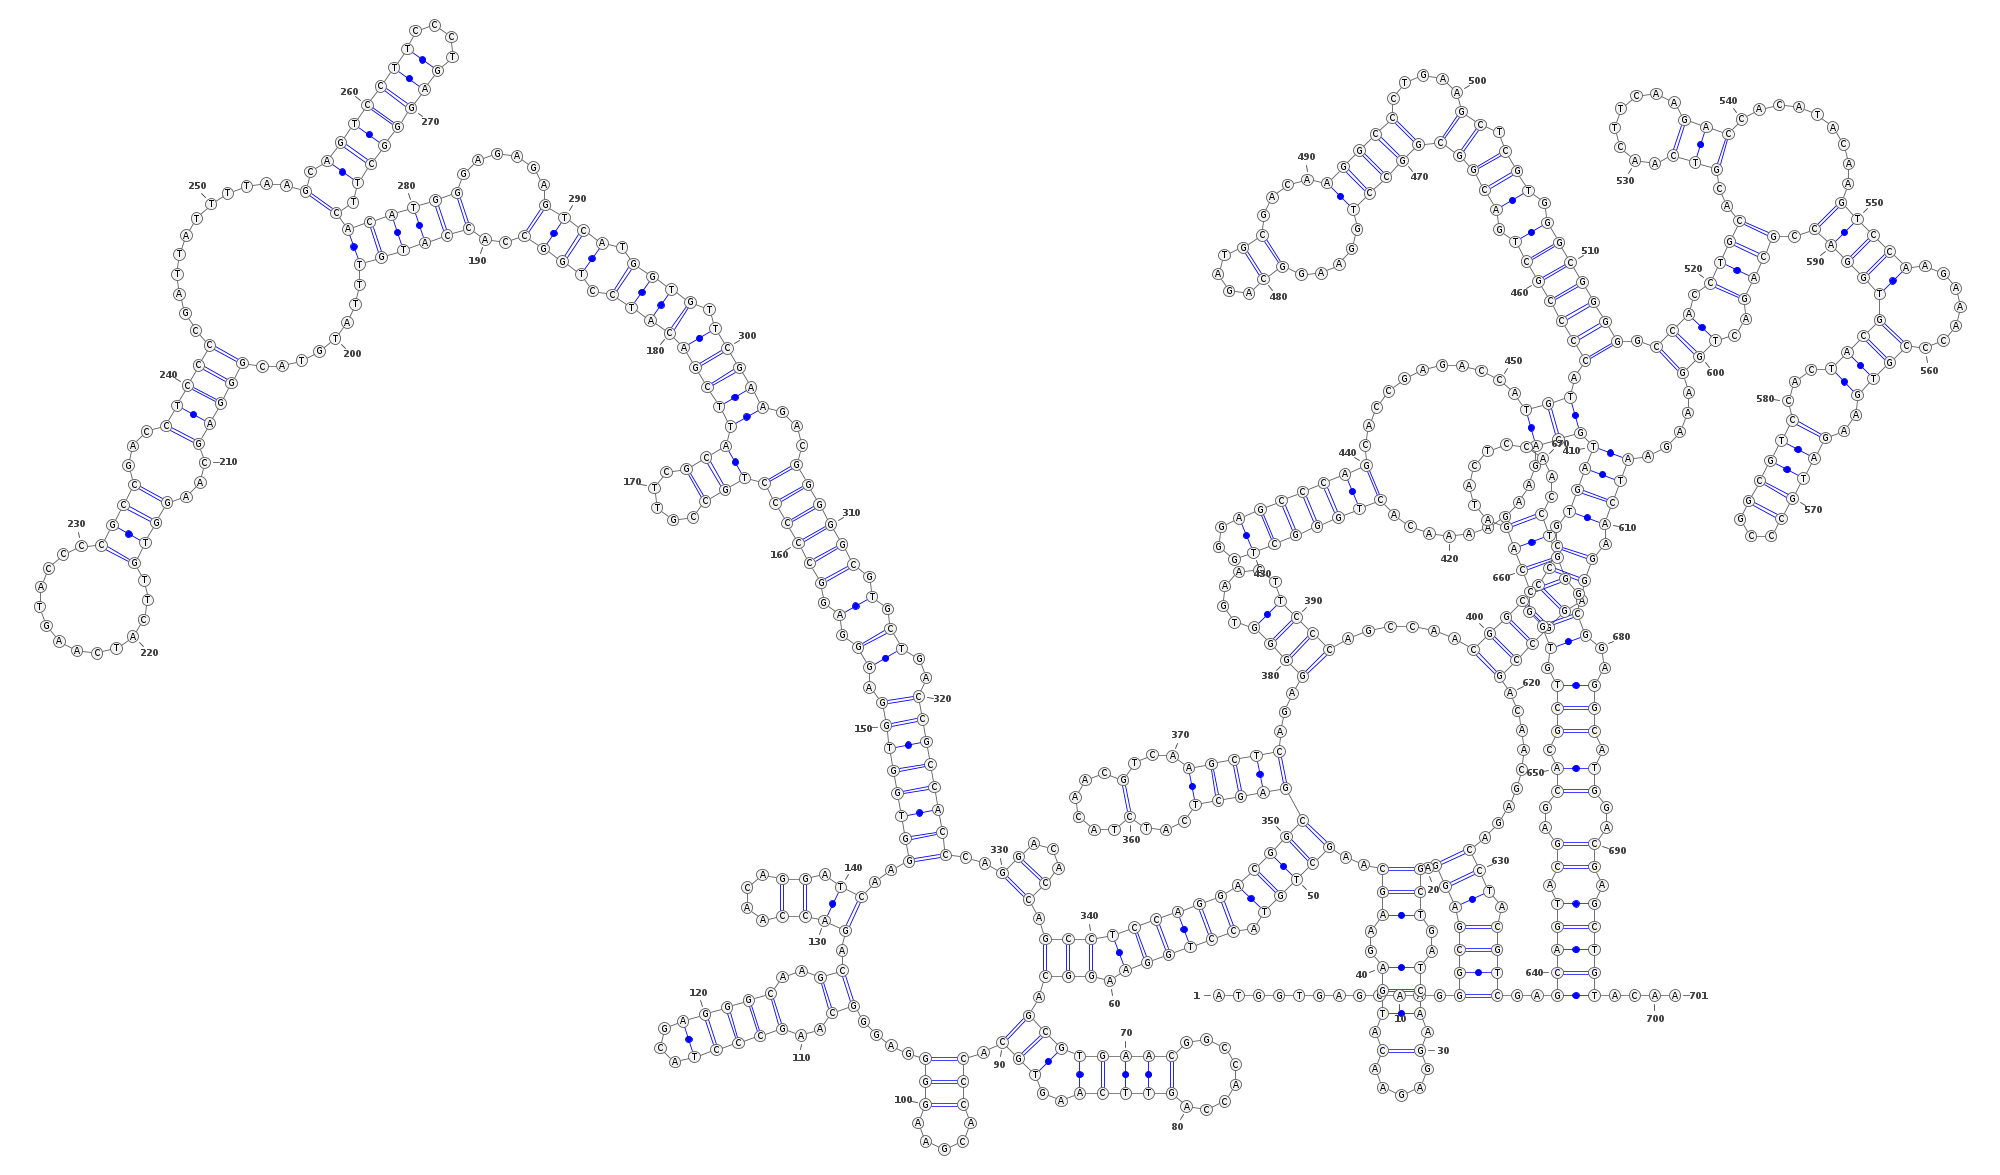

In [22]:
show_rna_structure(ViennaRNA.fold(cyrfp1_seq)[0], cyrfp1_seq, resolution=5)

['java', '-cp', './VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', 'ATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCCTGACCTACGGCGTGCAGTGCTTCAGCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGATCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCGCCCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGTAA', '-structureDBN', '..((((((((...((.....))))))))))(((((..(((((.((((((.((.((((((((((..........)))....))))))).)).)))).)))))))((((((.((((......)))).((.((.(.((((((((((((......(((.....(((

Output file: /tmp/tmp2dao87w3.png



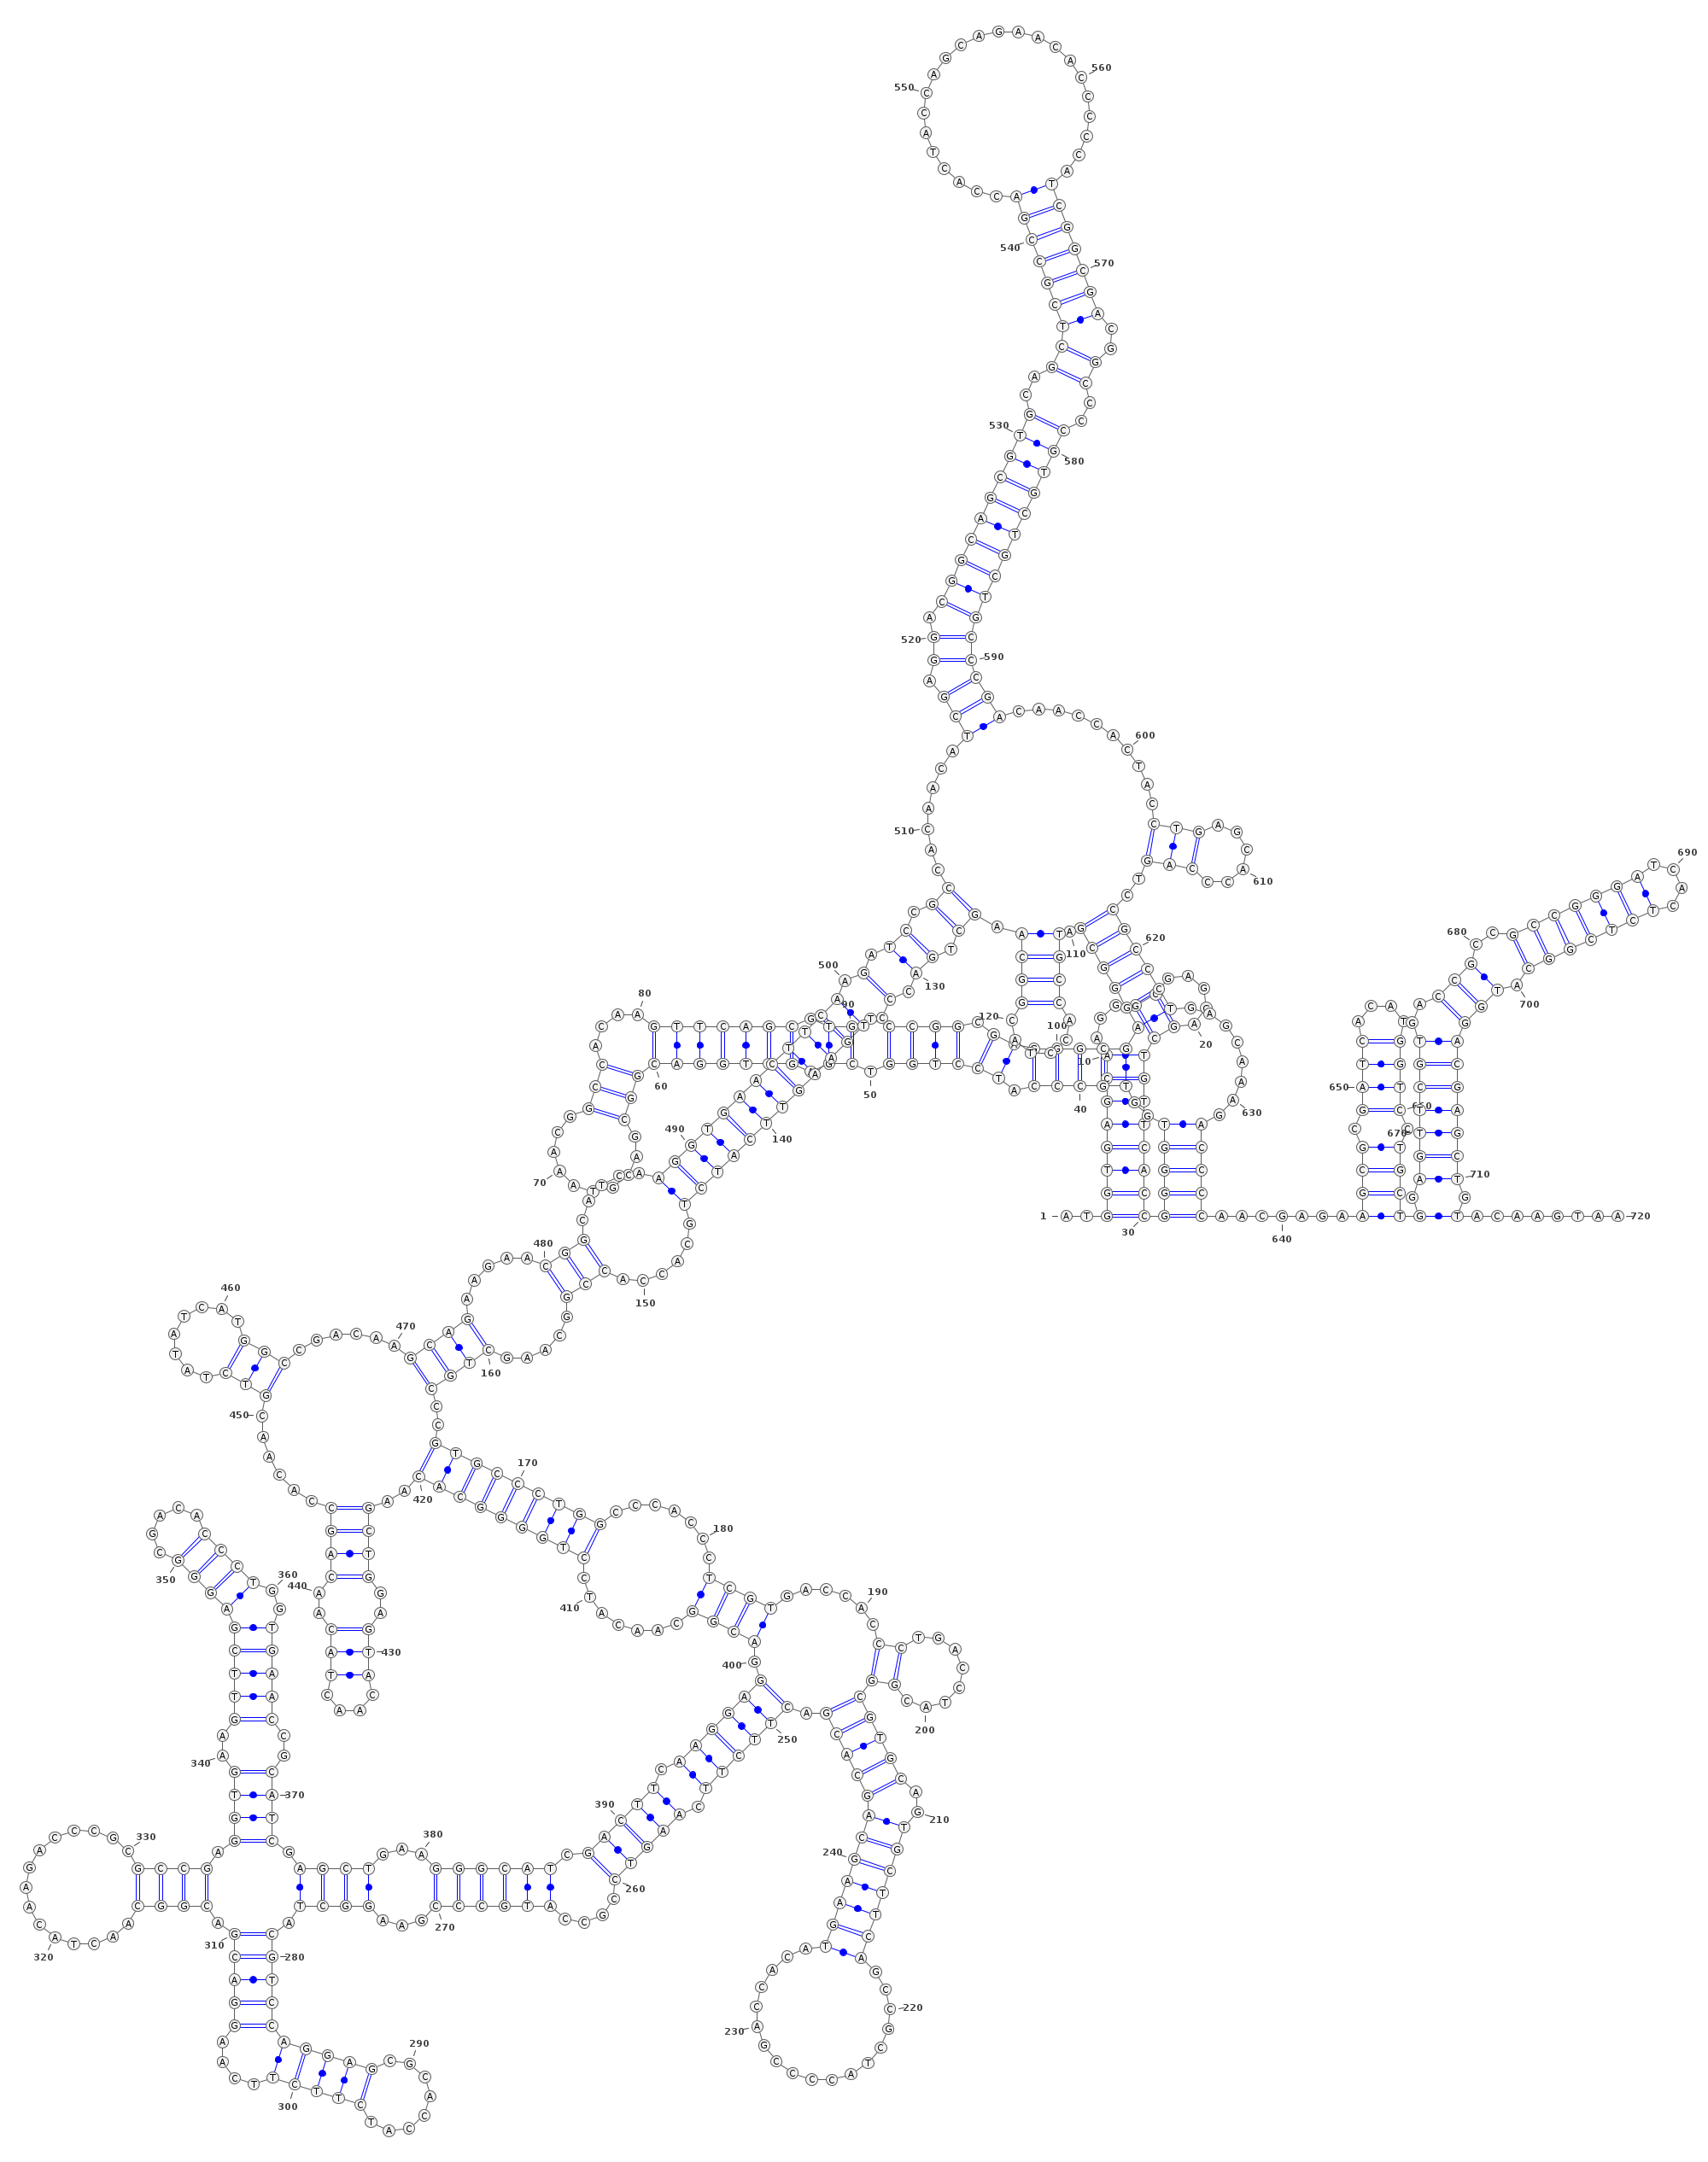

In [23]:
show_rna_structure(ViennaRNA.fold(egfp_seq)[0], egfp_seq, resolution=5)